Import libraries

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import optimize
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Initialising seed for np
np.random.seed(0)

Load dataset

In [3]:
# Dataset is uploaded to the below link
data_url = 'https://raw.githubusercontent.com/suryadesu/Datasets/main/BikeSharingDemand.csv'
df = pd.read_csv(data_url,sep=",")
df = df.drop(['dteday'],axis=1) # dteday is captured using yr, month, day
print(df.columns) 

Index(['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')


Some statistics of the data

In [4]:
def get_counts(feature,count):
    res = {}
    for c in range(len(feature)):
        res[feature[c]] = res.get(feature[c],0) + count[c]
    return res 

In [5]:
yr = df['yr']
count = df['cnt']
mnthM = (df['yr']+1)*df['mnth']

k = get_counts(yr,count)
print(f'Mean count per year: {np.mean(list(k.values()))}')

k = get_counts(mnthM,count)
print(f'Mean count per month: {np.mean(list(k.values()))}')

mean_hr = np.mean(list(df['cnt'])) # As the dataset used is hour.csv, each row is for each hour
print(f'Mean count per hour: {mean_hr}')

Mean count per year: 1646339.5
Mean count per month: 182926.61111111112
Mean count per hour: 189.46308763450142


Plot count vs features

In [6]:
def plotFeatures(V,fig=0):
    V = list(V.items())
    V.sort()
    X = [x[0] for x in V]
    Y = [x[1] for x in V]
    plt.figure(fig)
    plt.plot(X,Y)
    plt.show()

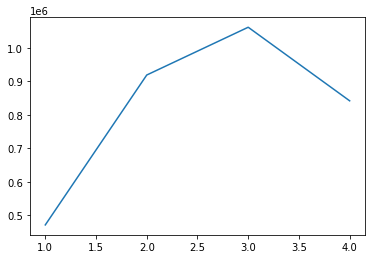

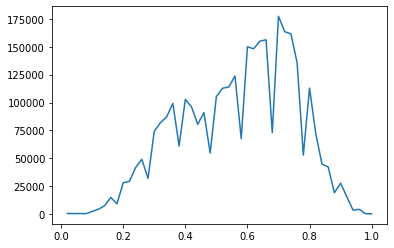

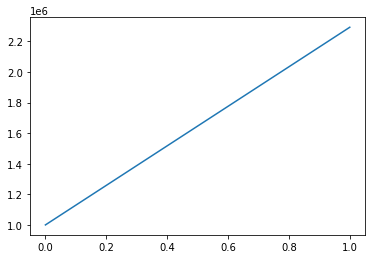

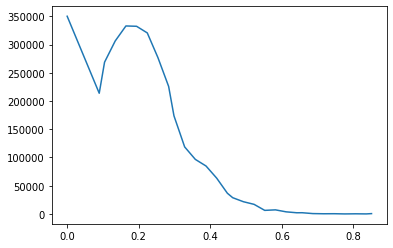

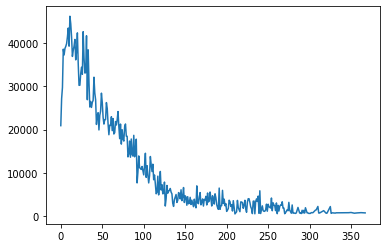

In [7]:
# Five features picked are season, working day, temp, windspeed, casual
season = df['season']
work_day = df['workingday']
temp = df['temp']
windspeed  = df['windspeed']
casual = df['casual']
plotFeatures(get_counts(season,count),1)
plotFeatures(get_counts(temp,count),2)
plotFeatures(get_counts(work_day,count),3)
plotFeatures(get_counts(windspeed,count),4)
plotFeatures(get_counts(casual,count),5)

Poisson Regression

In [8]:
class PoissonRegressor(object):
    """
    A class used to represent Poisson Regression
    ...

    Attributes
    ----------
    theta : array
        Parameters for the model
    alphaL1 : float
        regularization constant for l1-norm regularization
    alphaL2 : float
        regularization constant for l1-norm regularization
    
    Methods
    -------
    fit(X, Y)
        learns the parameters from given Input and Output Labels. Used for training
    predict(x)
        returns predicted value for given input. Used for validation and testing
    objective(theta,x,y)
        computes loss value for given input and output information and parameter
    get_rmse(x,y)
        computes rmse value for error between values predicted by the model for x and y
    
    """

    def __init__(self,alphaL1=0,alphaL2=0):
        self.alphaL1 = alphaL1
        self.alphaL2 = alphaL2
        return

    def fit(self,x,y):
        self.theta = np.random.rand(x.shape[1])
        self.theta = scipy.optimize.minimize(self.objective, self.theta, args=(xtrain,ytrain),method='BFGS').x
        return

    def predict(self,x):
        return np.exp(np.dot(x,self.theta.T))

    def objective(self,theta,x,y):
        thetaX = np.dot(x,theta.T)
        l1 = np.linalg.norm(theta,ord=1)
        l2 = np.linalg.norm(theta,ord=2)
        loss = -(y*thetaX - np.exp(thetaX)).sum() + self.alphaL1*l1 + self.alphaL2*l1
        return loss

    def get_rmse(self,xtest,ytest):
        rmse = np.sqrt(np.sum(np.square(self.predict(xtest)-ytest)))
        return rmse

Preprocessing

In [9]:
# MinMax normalization of casual and registered data whose values 
cols_to_norm = df.columns.drop(['cnt'])
df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max()-x.min()))

In [10]:
# Train, val, test split of the data
# Total data is split as 80-20 into trainVal and test
# trainVal data is again split as 80-20 into train and val 
train_test_mask = np.random.rand(len(df)) < 0.8
df_trainVal = df[train_test_mask]
df_test = df[~train_test_mask]

train_val_mask = np.random.rand(len(df_trainVal)) < 0.8
df_train = df_trainVal[train_val_mask]
df_val = df_trainVal[~train_val_mask]

ytrain = np.array(df_train['cnt'])
xtrain = np.array(df_train.drop(['cnt'],axis=1))

yval = np.array(df_val['cnt'])
xval = np.array(df_val.drop(['cnt'],axis=1))

ytest = np.array(df_test['cnt'])
xtest = np.array(df_test.drop(['cnt'],axis=1))

In [11]:
# Training the poisson regression model
# With no normalization
regressor = PoissonRegressor()
regressor.fit(xtrain,ytrain)

In [ ]:
# Testing with no normalization
print(regressor.get_rmse(xtest,ytest))

In [ ]:
ref = ref = [10**(x) for x in range(-10,21)]
# With l1-norm regularization

# Finding best hyperparameter for l1 norm
m = 0
k = 0
for L1 in ref:
    regressor = PoissonRegressor(alphaL1=L1)
    regressor.fit(xtrain,ytrain)
    score = regressor.get_rmse(xval,yval)
    if m == 0 or m > score:
            m = score
            print(m)
            k = L1
best_alphaL1 = k

In [14]:
# Testing for l1 norm regularization
regressor = PoissonRegressor(alphaL1 = best_alphaL1)
regressor.fit(xtrain,ytrain)
score = regressor.get_rmse(xtest,ytest)
print(score)

8834.383353888727


In [ ]:
# With l2-norm regularization

# Finding best hyperparameter for l2 norm
m = 0
k = 0
for L2 in ref:
    regressor = PoissonRegressor(alphaL2=L2)
    regressor.fit(xtrain,ytrain)
    score = regressor.get_rmse(xval,yval)
    if m == 0 or m > score:
            m = score
            print(m)
            k = L2
best_alphaL2 = k

In [16]:
# Testing for l2 norm regularization
regressor = PoissonRegressor(alphaL2=best_alphaL2)
regressor.fit(xtrain,ytrain)
score = regressor.get_rmse(xtest,ytest)
print(score)

8847.063033262993


In [19]:
# Testing with both regularizations
regressor = PoissonRegressor(alphaL1 = best_alphaL1,alphaL2=best_alphaL2)
regressor.fit(xtrain,ytrain)
score = regressor.get_rmse(xtest,ytest)
print(score)

8926.341261701898


Analysing important features

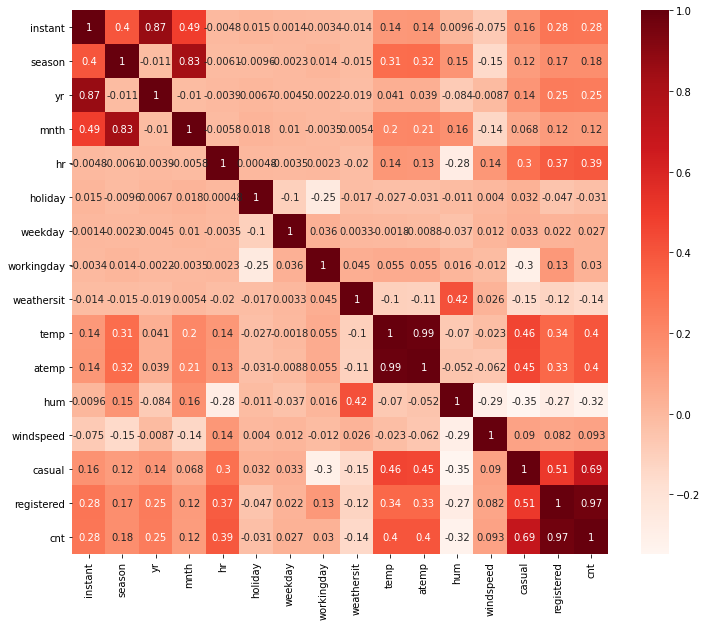

In [18]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()